# 最適化ロジック 動作確認・制御計画検証ノートブック

このノートでは `optimization/optimizer.py` の処理を段階的に確認し、出力制御計画を可視化して検証します。

検証内容:
- マスタ/天気/履歴データの読み込み
- 類似パターン抽出 → 快適性フィルタ → ベストパターン選択の確認
- 戦略（hourly / similar_day）を切替可能（similar_days_kも）
- 全ゾーンの計画出力と簡易可視化



In [1]:
import os
import sys
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォント
plt.rcParams['font.family'] = ['Hiragino Sans', 'IPAexGothic', 'Noto Sans CJK JP', 'Arial Unicode MS', 'TakaoGothic']
plt.rcParams['axes.unicode_minus'] = False

# プロジェクトルート
cwd = Path.cwd()
project_root = cwd.parent if cwd.name == 'notebooks' else cwd
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print('Project root:', project_root)



Project root: /Users/tomokiinoue/Desktop/workspace/AIrux8_opti_logic


In [2]:
# 設定
STORE = 'Clea'
STRATEGY = 'hourly'  # 'hourly' or 'similar_day'
SIMILAR_DAYS_K = 15  # only used when STRATEGY='similar_day'
START_DATE = '2025-09-29'
END_DATE = '2025-10-04'

print(f'Store={STORE}, Strategy={STRATEGY}, k={SIMILAR_DAYS_K}, Period={START_DATE}..{END_DATE}')



Store=Clea, Strategy=hourly, k=15, Period=2025-09-29..2025-10-04


In [3]:
from optimization.optimizer_runner import OptimizerRunner
from optimization.optimizer import Optimizer
from processing.utilities.master_data_loader import master_data_loader_runner
from config.utils import get_data_path

# マスタ読み込み
master_data = master_data_loader_runner(STORE)
assert master_data is not None, 'Master data not loaded'

# 予報読み込み（キャッシュ or API）
runner = OptimizerRunner(store_name=STORE)
runner.load_weather_data(START_DATE, END_DATE)
forecast_df = runner.weather_data.copy()
print('Forecast:', forecast_df.shape, forecast_df['datetime'].min(), '->', forecast_df['datetime'].max())

# 履歴特徴量CSVパス
features_csv_path = os.path.join(get_data_path('processed_data_path'), STORE, 'features_processed_Clea.csv')
print('Features CSV:', features_csv_path)

# Optimizer インスタンス
opt = Optimizer(use_operating_hours=False, strategy=STRATEGY, similar_days_k=SIMILAR_DAYS_K)

# 履歴読込
hist_df = opt.load_historical_patterns(features_csv_path)
print('Hist valid:', hist_df.shape, 'zones=', sorted(hist_df['zone'].unique()))



[MasterDataLoader] Building master data from consolidated 制御マスタ sheet: /Users/tomokiinoue/Desktop/workspace/AIrux8_opti_logic/data/01_MasterData/MASTER_Clea.xlsx
[MasterDataLoader] Available sheets: ['施設情報', 'MASTER', '制御マスタ', '設備マスタ', 'パラメータ', 'original']
[MasterDataLoader] Current month: 10 (10月)
[MasterDataLoader] Excelファイルを読み込み中: /Users/tomokiinoue/Desktop/workspace/AIrux8_opti_logic/data/01_MasterData/MASTER_Clea.xlsx
[MasterDataLoader] Excel 施設情報 sheet読み込み成功: shape=(4, 3)
[MasterDataLoader] Excel columns: ['施設情報', '値', '説明']
[MasterDataLoader] Coordinates from 施設情報 sheet: 35.681236%2C139.767124
[MasterDataLoader] Processing MASTER sheet for equipment mapping: shape=(26, 19)
[MasterDataLoader] Found zones in MASTER: ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Meeting Room', 'Break Room']
[MasterDataLoader] Initialized zone: Area 1
[MasterDataLoader] Initialized zone: Area 2
[MasterDataLoader] Initialized zone: Area 3
[MasterDataLoader] Initialized zone: Area 4
[MasterDataLoader] Ini

In [4]:
# 類似→快適→ベスト 選択の動作確認（1ゾーン×1時刻）
ZONE = sorted(hist_df['zone'].unique())[0]
TARGET_TS = forecast_df.iloc[0]['datetime']  # 先頭の時刻
row = forecast_df[forecast_df['datetime'] == TARGET_TS].iloc[0]

print('ZONE=', ZONE, 'TS=', TARGET_TS)

sim_df = opt._find_similar_patterns(hist_df, row, ZONE, n_top=20)
print('Similar candidates:', sim_df.shape)

month = pd.to_datetime(row['datetime']).month
comfort_df = opt._filter_by_comfort(sim_df, ZONE, month, master_data)
print('Comfort pass:', comfort_df.shape)

best = opt._select_best_pattern(comfort_df, TARGET_TS.hour, ZONE, month, master_data)
print('Best pattern row exists:', best is not None)
if best is not None:
    display(best)



ZONE= Area 1 TS= 2025-09-29 00:00:00
Similar candidates: (20, 23)
Comfort pass: (9, 23)
Best pattern row exists: True


Datetime               2024-10-03 00:00:00
Date                            2024-10-03
A/C Set Temperature                   25.0
Indoor Temp.                          23.9
A/C ON/OFF                             0.0
A/C Mode                               1.0
A/C Fan Speed                          0.0
A/C Status                             0.0
adjusted_power                     27300.0
Outdoor Temp.                         25.1
Outdoor Humidity                     81.96
Solar Radiation                        0.0
zone                                Area 1
DayOfWeek                                3
Hour                                     0
Month                                   10
IsWeekend                                0
IsHoliday                                0
Indoor Temp. Lag1                     22.6
hour                                     0
temp_z                             0.58601
solar_z                          -0.705591
similarity_score                  0.022704
Name: 51415

[Optimizer] Area 1: 快適範囲 23.2-26.0°C

━━━━━ [Area 1] Summary ━━━━━
✅ 成功: 136時間 (94%)
📊 失敗時間の平均: 類似パターン 13.5件 → 快適範囲通過 0件
🌡️ 快適性なし: 8時間
   10/01 16:00: 類似パターン=18件 → 快適範囲通過=0件 (必要=24.9-28.0°C, 実際=15.4-24.5°C)
   10/01 19:00: 類似パターン=18件 → 快適範囲通過=0件 (必要=24.9-28.0°C, 実際=13.5-24.2°C)
   10/01 20:00: 類似パターン=13件 → 快適範囲通過=0件 (必要=24.9-28.0°C, 実際=17.6-24.8°C)
   10/01 21:00: 類似パターン=12件 → 快適範囲通過=0件 (必要=24.9-28.0°C, 実際=17.2-23.2°C)
   10/01 22:00: 類似パターン=7件 → 快適範囲通過=0件 (必要=24.9-28.0°C, 実際=17.9-24.5°C)
   10/04 19:00: 類似パターン=18件 → 快適範囲通過=0件 (必要=24.9-28.0°C, 実際=13.5-24.2°C)
   10/04 20:00: 類似パターン=10件 → 快適範囲通過=0件 (必要=24.9-28.0°C, 実際=19.4-22.6°C)
   10/04 21:00: 類似パターン=12件 → 快適範囲通過=0件 (必要=24.9-28.0°C, 実際=20.0-24.2°C)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
[Optimizer] Area 2: 快適範囲 25.0-28.1°C

━━━━━ [Area 2] Summary ━━━━━
✅ 成功: 143時間 (99%)
📊 失敗時間の平均: 類似パターン 11.0件 → 快適範囲通過 0件
🌡️ 快適性なし: 1時間
   10/02 09:00: 類似パターン=11件 → 快適範囲通過=0件 (必要=23.7-27.0°C, 実際=27.1-29.7°C)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
[Optimizer] Area 3: 快

,datetime,forecast_outdoor_temp,forecast_solar_radiation,Area 1_set_temp,Area 1_mode,Area 1_fan_speed,Area 1_numb_units_on,Area 1_ac_on_off,Area 1_power,Area 1_indoor_temp,...,Meeting Room_fan_speed,Meeting Room_numb_units_on,Meeting Room_ac_on_off,Meeting Room_power,Meeting Room_indoor_temp,Meeting Room_similarity_score,Meeting Room_hist_outdoor_temp,Meeting Room_hist_solar_radiation,Meeting Room_hist_indoor_temp,Meeting Room_hist_datetime_used
0,2025-09-29 00:00:00,24.8,0.0,25.0,COOL,AUTO,0.0,OFF,27300.0,23.9,...,AUTO,0.0,OFF,4355.0,25.5,0.02,25.1,0.0,25.5,2024-10-03 00:00:00
1,2025-09-29 01:00:00,24.8,0.0,24.0,COOL,HIGH,7.0,ON,262325.0,25.5,...,AUTO,0.0,OFF,3005.0,27.0,0.02,24.6,0.0,27.0,2024-10-05 01:00:00
2,2025-09-29 02:00:00,24.8,0.0,25.0,COOL,LOW,7.0,ON,191765.0,25.6,...,AUTO,0.0,OFF,2070.0,27.8,0.02,24.6,0.0,27.8,2024-10-05 02:00:00
3,2025-09-29 03:00:00,24.7,0.0,25.0,COOL,LOW,7.0,ON,257250.0,25.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,2025-09-29 04:00:00,24.8,0.0,24.0,COOL,HIGH,8.0,ON,339955.0,24.4,...,AUTO,0.0,OFF,2405.0,26.1,0.00,24.8,0.0,26.1,2024-07-03 04:00:00


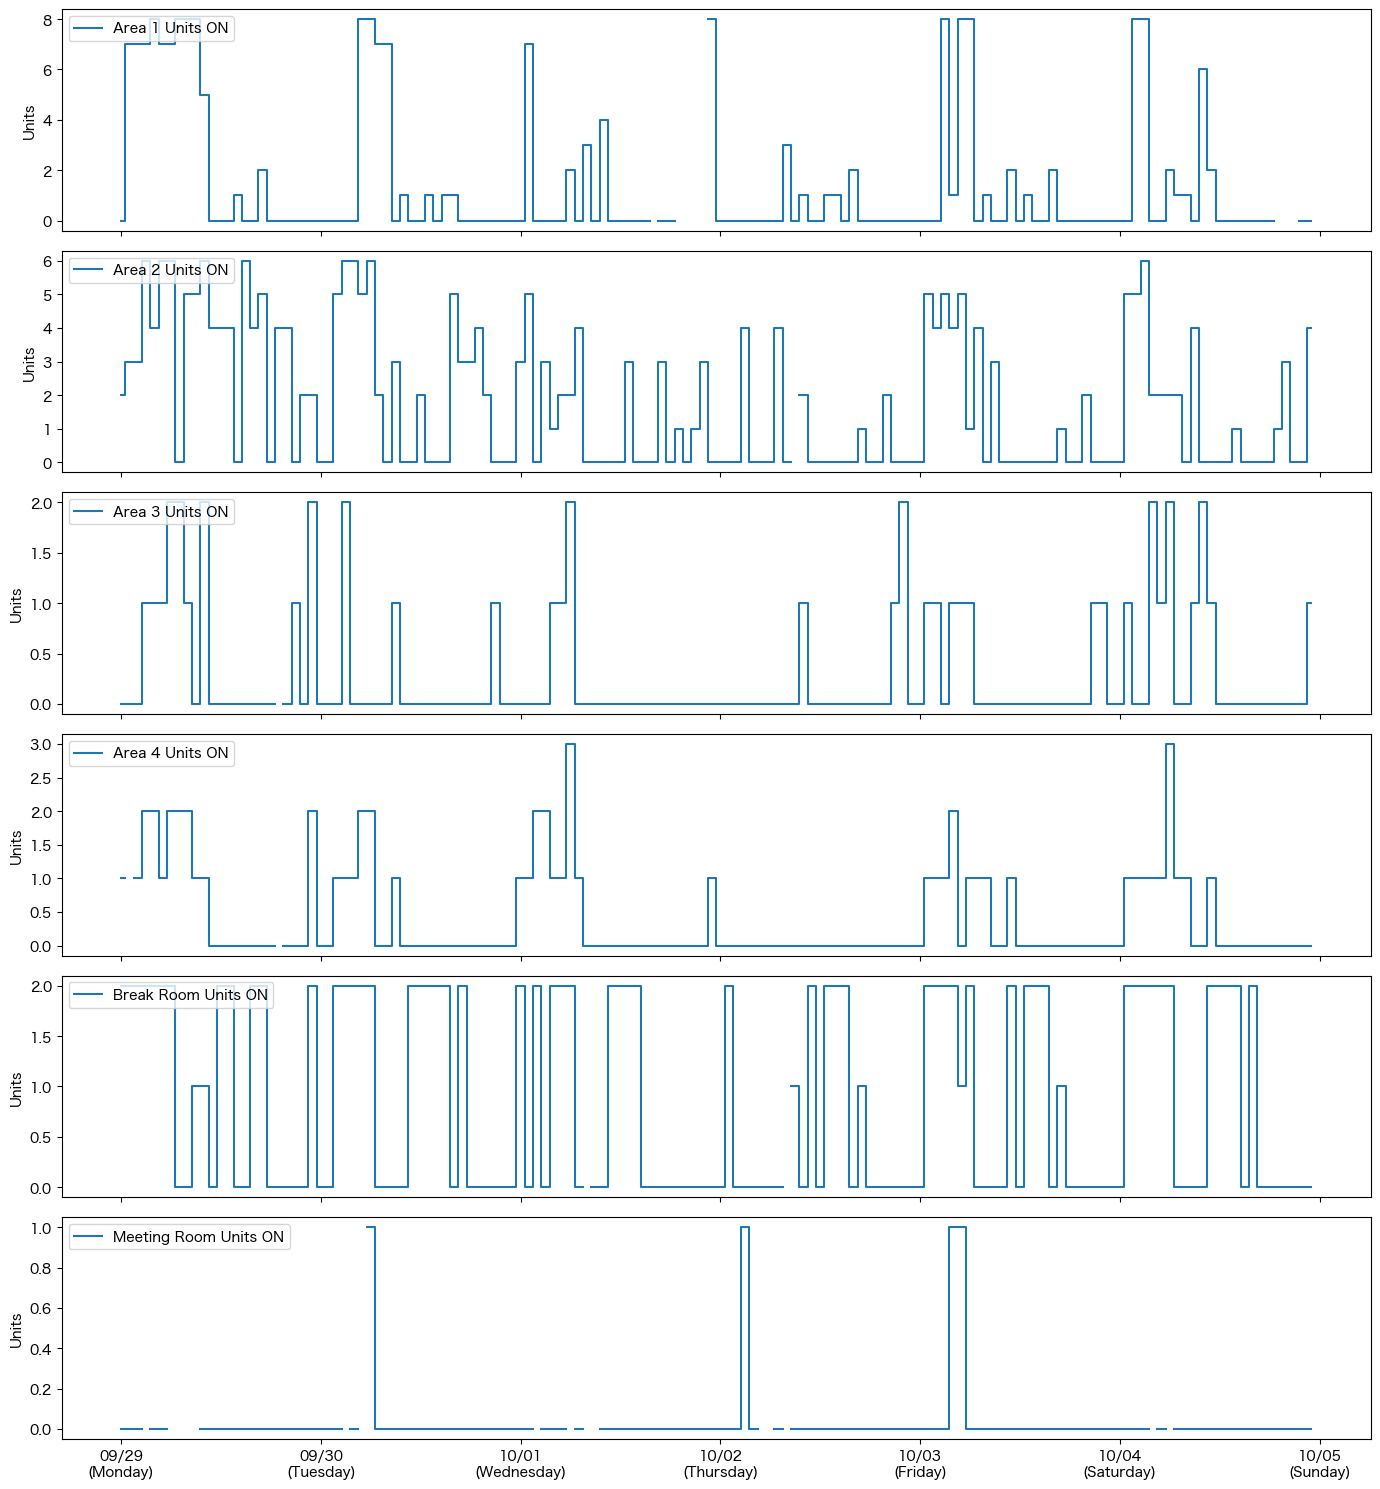

In [5]:
# 期間全体の最適化（検証用）
wide_df = opt.optimize_all_zones(forecast_df, features_csv_path, master_data)
print('Result (wide):', wide_df.shape)
display(wide_df.head())

# ゾーン別の簡易可視化
import matplotlib.dates as mdates

zones = sorted(hist_df['zone'].unique())
fig, axes = plt.subplots(len(zones), 1, figsize=(14, 2.5*len(zones)), sharex=True)
if len(zones) == 1:
    axes = [axes]
for ax, z in zip(axes, zones):
    ax.step(wide_df['datetime'], wide_df[f'{z}_numb_units_on'], where='mid', label=f'{z} Units ON')
    ax.set_ylabel('Units')
    ax.legend(loc='upper left')
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n(%A)'))
axes[-1].xaxis.set_major_locator(mdates.DayLocator())
plt.tight_layout()
plt.show()

